In [2]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import random
from faker import Faker
import numpy as np
import string
import os
import shutil
import csv
import json

In [14]:
#define font list
fonts = []

for root, dirs, files in os.walk('/usr/share/fonts/truetype/liberation2'):
    for file in files:
        if file.endswith('.ttf'):
            fonts.append(os.path.join(root, file))
            
for root, dirs, files in os.walk('/usr/share/fonts/truetype/dejavu'):
    for file in files:
        if file.endswith('.ttf'):
            fonts.append(os.path.join(root, file))

            
#generate fake profiles with Faker
def getRandomProfile():
    localized_providers = ["fr_FR", "en_US", "es_ES"]
    date_separators = ["/", "|", ".", "-", " "]
    date_prefix = ["", "DOB:", "DOB: ","[DOB]:", "[DOB]: "]
    sex_brackets = ["[?]", "(?)", "|?|", "?", "{?}"]
    
    date_sep = date_separators[random.randint(0,len(date_separators)-1)]
    
    fake = Faker(localized_providers[random.randint(0,len(localized_providers)-1)])
    profile = fake.simple_profile()

    return (
        profile["name"].upper(),
        sex_brackets[random.randint(0,len(sex_brackets)-1)].replace('?',profile["sex"]),
        date_prefix[random.randint(0, len(date_prefix)-1)] + profile["birthdate"].strftime("%d{}%m{}%Y".format(date_sep,date_sep))
    )

def get_dimensions(word, font):
    canvas = Image.new('RGB', (500,150))

    # Get a drawing context
    draw = ImageDraw.Draw(canvas)
    
    box = draw.textbbox((0, 0), word, font)
    text_width, text_height = box[2] - box[0], box[3] - box[1]
    
    return text_width*1.05, text_height *1.15
    
def draw_profile(boxes, image, position, font, profile = None):
    width, height = image.size
        
    draw = ImageDraw.Draw(image)

    if profile is None:
        profile = getRandomProfile()
        
    name,sex,dob = profile
    
    x,y = position
    
    spaceX = random.randint(20,30)
    spaceY = random.randint(5,15)
    
    # draw name
    name_array = name.split()
    for word in name_array:
        text_width, text_height = get_dimensions(word, font)
        
        if x + text_width > 0.99*width:
            y += (text_height + spaceY)
            x = position[0]
        
        draw.text((x, y), word, font=font, fill = "#fff")
        box = (x/width, y/height, min((x+text_width)/width,1.0), min((y+text_height*1.15)/height,1.0))
        boxes.append((word,box))
        
        x += (text_width + spaceX)

    #draw sex
    text_width, text_height = get_dimensions(sex, font)

    if x + text_width > 0.99*width:
        y += (text_height + spaceY)
        x = position[0]
    
    draw.text((x, y), sex, font=font, fill = "#fff")
    box = (x/width, y/height, min((x+text_width)/width,1.0), min((y+text_height*1.15)/height,1.0))
    boxes.append((sex,box))
    
    #draw dob (linebreak with 75% probability or if needed when close to border)
    if random.randint(0,3) < 3 or x + text_width > 0.99*width:
        y += (text_height + spaceY)
        x = position[0]
    else:
        x += (text_width + spaceX)
        
    dob_array = dob.split()
    for word in dob_array:
        text_width, text_height = get_dimensions(word, font)
        
        if x + text_width > 0.99*width:
            y += (text_height + spaceY)
            x = position[0]
        
        draw.text((x, y), word, font=font, fill = "#fff")
        box = (x/width, y/height, min((x+text_width)/width,1.0), min((y+text_height*1.15)/height,1.0))
        boxes.append((word,box))
        
        x += (text_width + spaceX)

def draw_random(boxes, image, position, font, angle = 0):
    width, height = image.size
        
    draw = ImageDraw.Draw(image)
    
    #random string of 1 to 4 char
    random_string = ''.join(random.choices(string.ascii_uppercase + string.digits, k=random.randint(1,4)))

    x,y = position
    text_width, text_height = get_dimensions(random_string, font)
    
    if angle > 0:
        layer = Image.new('L', (int(text_width),int(text_height*1.2)))
        dr = ImageDraw.Draw(layer)
        dr.text((0, 0), random_string, font=font, fill="#fff")

        layer = layer.rotate(angle, expand = True)
        image.paste(layer, (x,y), layer)
        
        w,h = layer.size
        box = (x/width, y/height, min((x+w)/width,1.0), min((y+h)/height,1.0))
        boxes.append((random_string,box))
    else:
        draw.text((x, y), random_string, font=font, fill = "#fff")

        text_width, text_height = get_dimensions(random_string, font)
        box = (x/width, y/height, min((x+text_width)/width,1.0), min((y+text_height*1.15)/height,1.0))
        boxes.append((random_string,box))
        

def getRandomFont(fontsize = random.randint(30,65)):
    font_path = fonts[random.randint(0, len(fonts)-1)]
    font = ImageFont.truetype(font_path, fontsize)
    return font

def draw(input_dir,output_dir, file, n_profile, n_random, j):
    image_name = file.split(".")[0]

    image = Image.open(os.path.join(input_dir,file))

    width, height = image.size

    draw = ImageDraw.Draw(image)

    boxes = []

    for i in range(n_profile):
        x = random.randint(15,int(0.8*width))
        y = random.randint(0,int(0.92*height))
        font = getRandomFont(random.randint(25,int(0.05*height)))
        draw_profile(boxes,image, (x,y),font)

    for i in range(n_random):
        x = random.randint(0,int(0.85*width))
        y = random.randint(0,int(0.95*height))
        angles = [0,0,0,0,0,0,0,0,0,2,4,8,10,12,15,90,270]
        draw_random(boxes,image, (x,y),getRandomFont(random.randint(30,int(0.05*height))),angles[random.randint(0,len(angles)-1)])

    output_file = os.path.join(output_dir, image_name + '_' + str(j)+".jpeg")
    image.save(output_file)

    return output_file, boxes

def plot_example(input_dir, filename, bboxes):
    plt.figure(figsize = (8,8))
    img = cv2.imread(os.path.join(input_dir, filename))

    height, width , _ = img.shape
    
    #print(height,width)

    plt.imshow(img)

    ax = plt.gca()

    for box in bboxes:
        xmin, ymin, w, h = box
        xmax = xmin + w
        ymax = ymin + h

        pos = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
        ax.add_patch(plt.Polygon(pos, fill=False, edgecolor="red", linewidth=1))

    plt.axis('off')
    plt.show()
    
def read_boxes_example(input_csv, filename):
    bboxes = []
    with open(input_csv, mode="r", newline="") as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row["image_name"] == filename:
                bboxes.append([int(row["bbox_x"]),int(row["bbox_y"]),int(row["bbox_width"]),int(row["bbox_height"])])
    return bboxes

#check if no text appears outside the image, resulting in boxes with 0 height or width,
#if it's the case, the image is dropped
def is_clean(bboxes, width, height):
    for _, box in bboxes:
        bbox_width, bbox_height = box[2] - box[0], box[3] - box[1]
        bbox_width, bbox_height = int(bbox_width*width), int(bbox_height*height)
        if bbox_width < 3 or bbox_height < 3:
            return False
    return True


## 1. Get manual annotations for hand-annotated dataset

In [69]:
hand_annotated_dir = "/mnt/hgfs/shared/coco/hand_annotated/"

# Define the name of the CSV file you want to read
hand_annot_filename = "/mnt/hgfs/shared/coco/annotations/hand_annotations.csv"

file_annot = {}

# Open the CSV file in "read" mode
with open(hand_annot_filename, mode="r", newline="") as csv_file:

    # Create a reader object using the csv library
    reader = csv.DictReader(csv_file)

    # Define an empty list to store the contents of the CSV file
    contents = []

    # Loop through each row in the CSV file
    for row in reader:
        if row["image_name"] not in file_annot:
            file_annot[row["image_name"]] = []
        file_annot[row["image_name"]].append(row)

#### Example

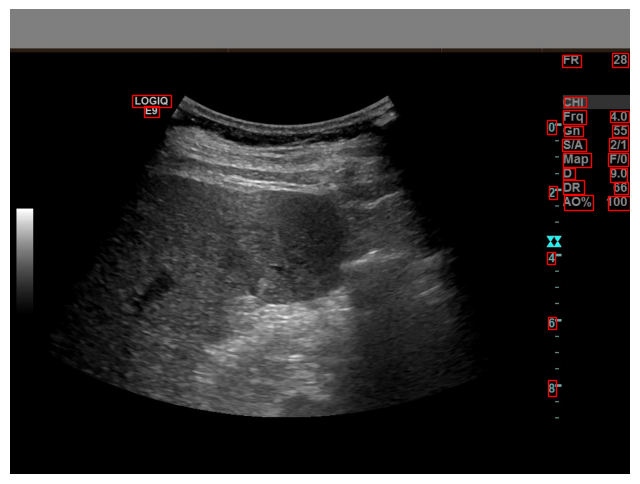

In [70]:
hand_example = "02015b84-017c4647-6e315445-760a7cd2-0c22c10c.jpg"

hand_bboxes = []
for annot in file_annot[hand_example]:
    hand_bboxes.append([int(annot["bbox_x"]),int(annot["bbox_y"]),int(annot["bbox_width"]),int(annot["bbox_height"])])
    
plot_example(hand_annotated_dir,hand_example,hand_bboxes)

## 2. Add random text to annotated dataset

In [91]:
hand_autom_annotated_dir = "/mnt/hgfs/shared/coco/hand_autom_annotated"

hand_autom_csv = "/mnt/hgfs/shared/coco/annotations/hand_autom_annot.csv"

fieldnames = ["label_name", "bbox_x", "bbox_y", "bbox_width", "bbox_height", "image_name", "image_width", "image_height"]

# Open the CSV file in "write" mode
with open(hand_autom_csv, mode="w", newline="") as csv_file:

    # Create a writer object using the csv library
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    # Write the first row (i.e., the fieldnames)
    writer.writeheader()
   
    for file, items in file_annot.items():
        if len(items) > 6: #if contains already many text instances
            n_dupplicate = 70 #number of time the drawing process is applied to the image
            n_profile = 1
            n_random = 5
        else:
            n_dupplicate = 100
            n_profile = 1
            n_random = 12
        for j in range(n_dupplicate):
            
            output_name, bboxes = draw(hand_annotated_dir,hand_autom_annotated_dir,file,n_profile,n_random,j)
            
            image_width, image_height = int(items[0]["image_width"]), int(items[0]["image_height"])
            
            #write new annot
            if is_clean(bboxes,image_width, image_height):
                for _, box in bboxes:
                    bbox_width, bbox_height = box[2] - box[0], box[3] - box[1]

                    row = {
                        'label_name': 'text',
                        'bbox_x': int(box[0]*image_width),
                        'bbox_y': int(box[1]*image_height),
                        'bbox_width': int(bbox_width*image_width), 
                        'bbox_height': int(bbox_height*image_height),
                        'image_name': output_name,
                        'image_width': image_width,
                        'image_height': image_height
                    }
                    writer.writerow(row)
            
                #write origin annot
                rows = items.copy()
                for row in rows:
                    row["image_name"] = output_name
                    writer.writerow(row)

#### Example

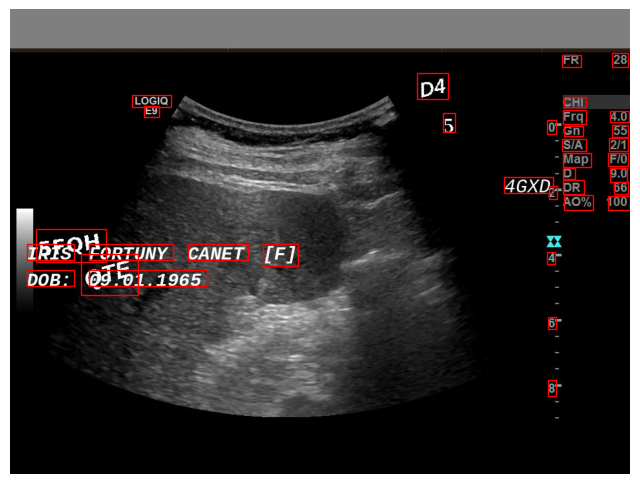

In [92]:
hand_autom_example = hand_example.split('.')[0] + "_0.jpeg"

hand_autom_bboxes = read_boxes_example(hand_autom_csv, os.path.join(hand_autom_annotated_dir, hand_autom_example))

plot_example(hand_autom_annotated_dir,hand_autom_example,hand_autom_bboxes)

## 3. Add random text to clean dataset

In [93]:
clean_dir = "/home/nico/Documents/original_data/training"

autom_annotated_dir = "/mnt/hgfs/shared/coco/autom_annotated"

autom_csv = "/mnt/hgfs/shared/coco/annotations/autom_annot.csv"

image_names = [f for f in os.listdir(clean_dir) if f.endswith(".jpg") or f.endwith(".jpeg")]

fieldnames = ["label_name", "bbox_x", "bbox_y", "bbox_width", "bbox_height", "image_name", "image_width", "image_height"]

# Open the CSV file in "write" mode
with open(autom_csv, mode="w", newline="") as csv_file:

    # Create a writer object using the csv library
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    n_dupplicate = 100
    n_profile = 2
    n_random = 12
    for file in image_names:
        for j in range(n_dupplicate):
            
            output_name, bboxes = draw(clean_dir,autom_annotated_dir,file,n_profile,n_random,j)
            
            img = cv2.imread(os.path.join(clean_dir,file))

            image_height, image_width, _ = img.shape
            
            #write new annot
            if is_clean(bboxes,image_width, image_height ):
                for _, box in bboxes:
                    bbox_width, bbox_height = box[2] - box[0], box[3] - box[1]

                    row = {
                        'label_name': 'text',
                        'bbox_x': int(box[0]*image_width),
                        'bbox_y': int(box[1]*image_height),
                        'bbox_width': int(bbox_width*image_width), 
                        'bbox_height': int(bbox_height*image_height),
                        'image_name': output_name,
                        'image_width': image_width,
                        'image_height': image_height
                    }
                    writer.writerow(row)


#### Example

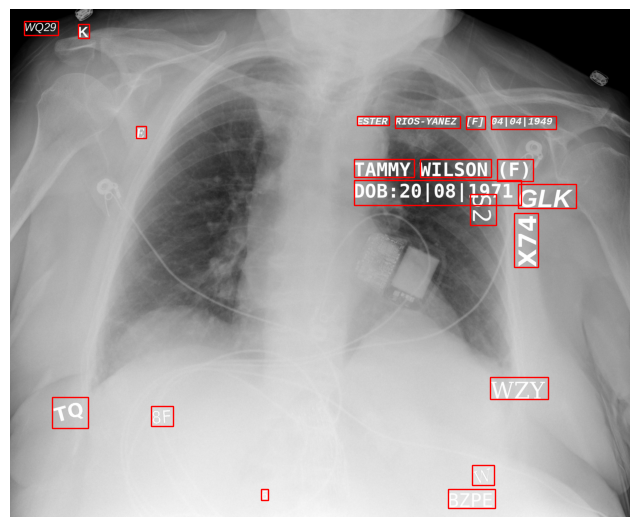

In [95]:
autom_example = "d6532832-4defe276-42599731-b08a7276-7bda34a4_0.jpeg"

autom_bboxes = read_boxes_example(autom_csv, os.path.join(autom_annotated_dir, autom_example))

plot_example(autom_annotated_dir,autom_example,autom_bboxes)

## 4. Concat csv

In [96]:
concat_csv = "/mnt/hgfs/shared/coco/annotations/concat_annot.csv"

fieldnames = ["label_name", "bbox_x", "bbox_y", "bbox_width", "bbox_height", "image_name", "image_width", "image_height"]
with open(concat_csv, mode="w", newline="") as out_file:
    writer = csv.DictWriter(out_file, fieldnames=fieldnames)

    writer.writeheader()

    with open(hand_autom_csv, mode="r", newline="") as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            writer.writerow(row)

    with open(autom_csv, mode="r", newline="") as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            writer.writerow(row)

## 5. Csv to json big, medium, small

In [101]:
annot = {}

with open(concat_csv, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader) #skip first line
    for row in spamreader:
        label, bbox_x, bbox_y, bbox_width, bbox_height, image_name, image_width, image_height = row
        if image_name not in annot:
            annot[image_name] = []
        annot[image_name].append(row)

files = list(annot.keys())
random.shuffle(files)

In [106]:
images_train = [[],[],[]]
annotations_train = [[],[],[]]

images_val = [[],[],[]]
annotations_val = [[],[],[]]

annotID = 1

destination_directory = '/mnt/hgfs/shared/coco'

n_train = int(len(files)*0.8)
for i, file in enumerate(files):
    image_name = file.split('/')[-1]
    
    first_row = annot[file][0]

    image_width, image_height = first_row[6], first_row[7]
        
    img_id = i
    
    new_image = {
        'file_name': image_name,
        'width': int(image_width),
        'height': int(image_height),
        'id': img_id
    }

    random_float = random.random()
    
    if i < n_train:
        images_train[0].append(new_image)
        if random_float < 0.7:
            images_train[1].append(new_image)
        if random_float < 0.3:
            images_train[2].append(new_image)
            
        dst = os.path.join(destination_directory,"new_custom_train_v2",image_name)
    else:
        images_val[0].append(new_image)
        if random_float < 0.7:
            images_val[1].append(new_image)
        if random_float < 0.3:
            images_val[2].append(new_image)
            
        dst = os.path.join(destination_directory,"new_custom_val_v2",image_name)
        
    shutil.copy(file, dst)
    
    for row in annot[file]:
        label_name, bbox_x, bbox_y, bbox_width, bbox_height, _, _, _ = row
        bbox = [int(bbox_x), int(bbox_y), int(bbox_width), int(bbox_height)]
        
        #coco format
        new_annot = {
            'area': int(bbox_width)*int(bbox_height),
            'iscrowd': 0,
            'image_id': img_id,
            'bbox': bbox,
            'category_id': 1,
            'id': annotID
        }

        if i < n_train:
            annotations_train[0].append(new_annot)
            if random_float < 0.7:
                annotations_train[1].append(new_annot)
            if random_float < 0.3:
                annotations_train[2].append(new_annot)
        else:
            annotations_val[0].append(new_annot)
            if random_float < 0.7:
                annotations_val[1].append(new_annot)
            if random_float < 0.3:
                annotations_val[2].append(new_annot)

        annotID += 1

for i, size in enumerate(["big","medium","small"]):
        
    info_train = {'description': "New Custom {} train dataset v2".format(size)}
    info_val = {'description': "New Custom {} val dataset v2".format(size)}


    categories = [{'id': 1, 'name': "text"}]

    # Build new JSON
    json_train_content = {
        'info': info_train,
        'images': images_train[i],
        'annotations': annotations_train[i],
        'categories': categories
    }
    json_val_content = {
        'info': info_val,
        'images': images_val[i],
        'annotations': annotations_val[i],
        'categories': categories
    }

    # Write the JSON to a file
    output_json_train_path = os.path.join(destination_directory, "annotations/new_custom_train_v2_{}.json".format(size))
    output_json_val_path = os.path.join(destination_directory, "annotations/new_custom_val_v2_{}.json".format(size))

    print('Saving new train {} json file...'.format(size))
    with open(output_json_train_path, 'w+') as output_file:
        json.dump(json_train_content, output_file)

    print('json train saved.')

    print('Saving new val {} json file...'.format(size))
    with open(output_json_val_path, 'w+') as output_file:
        json.dump(json_val_content, output_file)

    print('json val saved.')

Saving new train big json file...
json train saved.
Saving new val big json file...
json val saved.
Saving new train medium json file...
json train saved.
Saving new val medium json file...
json val saved.
Saving new train small json file...
json train saved.
Saving new val small json file...
json val saved.


## 6. Copy files to cism cluster

In [6]:
!scp -r /mnt/hgfs/shared/coco/new_custom_train_v2 manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco
!scp -r /mnt/hgfs/shared/coco/new_custom_val_v2 manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco
!scp /mnt/hgfs/shared/coco/annotations/new_custom_train_v2_big.json manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco/annotations
!scp /mnt/hgfs/shared/coco/annotations/new_custom_train_v2_medium.json manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco/annotations
!scp /mnt/hgfs/shared/coco/annotations/new_custom_train_v2_small.json manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco/annotations
!scp /mnt/hgfs/shared/coco/annotations/new_custom_val_v2_big.json manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco/annotations
!scp /mnt/hgfs/shared/coco/annotations/new_custom_val_v2_medium.json manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco/annotations
!scp /mnt/hgfs/shared/coco/annotations/new_custom_val_v2_small.json manneback:/CECI/home/ucl/ingi/nszelago/Thesis/SSD-pytorch/coco/annotations    

00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  274KB 182.0KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  261KB 247.7KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  280KB 215.4KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  271KB 257.5KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  265KB 303.2KB/s   00:00    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  263KB 335.4KB/s   00:00    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  273KB 243.5KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  271KB 213.1KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  264KB 248.7KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  276KB 261.3KB/s   00:01    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  267KB 275.6KB/s   00:00    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2b53c_ 100%  265KB 283.4KB/s   00:00    
00ade77e-b35a99fc-88893ac3-221cd03b-f3c2

02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  541KB   2.1MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  543KB   2.0MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  568KB   2.2MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  225KB   1.2MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  218KB   1.5MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  222KB   1.4MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  233KB   1.4MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  244KB   1.5MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  243KB   1.5MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  223KB   1.9MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  230KB   1.9MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  239KB   1.9MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed

06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  435KB   2.1MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  451KB   1.5MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  458KB   1.9MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  447KB   1.9MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  447KB   2.3MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  438KB   2.2MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  457KB   2.5MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  451KB   2.4MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  457KB   2.3MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  451KB   2.3MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  456KB   1.9MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8afd7_ 100%  449KB   2.6MB/s   00:00    
06978201-c1ef4c8c-71af28b0-845d5217-91c8

083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  323KB   1.1MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  337KB   1.0MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  339KB 984.9KB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  332KB 953.5KB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  331KB   1.1MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  333KB   1.0MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  324KB 957.8KB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  333KB   1.1MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  350KB   1.1MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  321KB   1.0MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  330KB   1.3MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f72b7_ 100%  330KB   1.5MB/s   00:00    
083862e7-be160453-492593da-d521ec6a-796f

08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  376KB   1.1MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  375KB   1.4MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  371KB   1.3MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  378KB   1.3MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  387KB   1.4MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  376KB   1.4MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  370KB   1.3MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  377KB   1.2MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  373KB   1.2MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  379KB   1.2MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  384KB   1.3MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c176384_ 100%  374KB   1.4MB/s   00:00    
08dafceb-84b70b01-90e0314f-0015b8ec-1c17

0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  448KB   2.0MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  466KB   2.0MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  456KB   2.1MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  454KB   1.8MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  451KB   2.0MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  446KB   1.9MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  450KB   2.2MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  444KB   2.4MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  449KB   2.2MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  443KB   2.2MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  450KB   2.3MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  462KB   2.4MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93f

10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  265KB 883.3KB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  276KB   2.4MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  272KB   2.1MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  263KB   1.8MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  276KB   2.0MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  291KB   1.6MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  283KB   1.0MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  270KB   1.9MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  299KB   2.3MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  270KB   1.4MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  293KB   1.9MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-294034c1_ 100%  270KB   1.9MB/s   00:00    
10befc0e-2d55cf59-2048cb67-6766ef1a-2940

16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  437KB 495.5KB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  431KB 465.0KB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  433KB 829.4KB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  432KB   2.2MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  423KB   1.1MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  450KB   1.0MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  428KB   1.2MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  441KB   1.1MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  439KB 980.3KB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  429KB   1.3MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  428KB   1.5MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-809014c6_ 100%  435KB   1.4MB/s   00:00    
16c809ce-ece9133b-b42d6f93-b81a4a16-8090

195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  356KB   1.6MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  347KB   2.0MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  357KB   2.0MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  347KB   1.6MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  355KB   1.7MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  361KB   1.9MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  347KB   1.8MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  352KB   1.8MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  358KB   2.1MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  351KB   1.9MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  346KB   2.0MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e21e57_ 100%  346KB   1.6MB/s   00:00    
195584d3-713a1d80-c00ff7fe-17892cbd-46e2

1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  333KB   1.3MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  327KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  346KB   1.5MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  337KB   1.7MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  327KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  338KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  339KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  334KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  336KB   2.1MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  317KB   1.5MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  322KB   1.7MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  317KB   1.8MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c0

210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  336KB   1.4MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  338KB   1.2MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  339KB 934.1KB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  336KB 933.0KB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  346KB 891.9KB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  344KB   1.9MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  346KB   1.8MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  342KB   1.8MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  340KB   1.8MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  356KB   1.6MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  345KB   1.8MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbdbb89_ 100%  358KB   1.4MB/s   00:00    
210d1ac2-e9f4a2ef-e3ad45e7-836fb2c7-cbbd

25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  504KB   2.1MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  518KB   2.3MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  501KB   2.5MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  505KB   2.3MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  511KB   1.7MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  504KB   2.1MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  508KB   1.9MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  513KB   2.2MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  523KB   2.3MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  514KB   2.6MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  517KB   2.3MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8eb330_ 100%  511KB   2.3MB/s   00:00    
25c14caa-f2532f22-6cb3b9c8-2d777678-7e8e

2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  149KB   1.4MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  145KB   1.1MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  144KB   1.2MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  143KB   1.3MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  146KB   1.5MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  142KB   1.4MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  144KB   1.0MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  144KB   1.1MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  146KB   1.2MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  147KB   1.3MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  145KB 612.7KB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-03760291_ 100%  146KB   1.2MB/s   00:00    
2ae45c00-7294109e-1b2e5cb9-a3a1b3b5-0376

2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  285KB   1.6MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  281KB   1.6MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  305KB   1.2MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  286KB   1.8MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  308KB   1.2MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  295KB   1.7MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  298KB   1.7MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  294KB   1.5MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  304KB   1.6MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  289KB   1.6MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  281KB   1.5MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  300KB   1.0MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec91

2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  414KB   1.2MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  405KB   1.1MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  396KB   1.1MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  408KB   1.1MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  400KB   1.0MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  407KB   1.1MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  406KB 979.8KB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  408KB   1.0MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  403KB   1.1MB/s   00:00    
2e777bd7-efd9a062-e9e66467-1e247db6-4bf10955_ 100%  405KB 945.1KB/s   00:00    
2e8e7179-bf0f5b30-f77b36b5-9cc572d9-7908b9bf_ 100%  231KB 658.9KB/s   00:00    
2e8e7179-bf0f5b30-f77b36b5-9cc572d9-7908b9bf_ 100%  223KB 674.5KB/s   00:00    
2e8e7179-bf0f5b30-f77b36b5-9cc572d9-7908

2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  404KB   1.3MB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  396KB   1.4MB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  403KB   1.5MB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  402KB   1.1MB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  401KB   1.1MB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  407KB 991.8KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  401KB 772.5KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  403KB 731.4KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  411KB 776.9KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  416KB 702.6KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  411KB 677.6KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886dd5e8_ 100%  404KB 698.0KB/s   00:00    
2fc8bdb8-f7f72eb5-b9c52b5e-e3f07c2b-886d

31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  472KB   1.4MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  489KB   1.6MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  490KB   1.4MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  498KB   1.3MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  471KB   1.2MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  488KB   1.1MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  478KB   1.3MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  474KB   1.1MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  477KB   1.0MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  483KB   1.1MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  486KB   1.1MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050e233_ 100%  491KB   1.1MB/s   00:00    
31526ae5-e1aa5a43-b9daeb9c-5899e51f-8050

329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  327KB   1.8MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  308KB   1.7MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  320KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  315KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  312KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  314KB   1.4MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  317KB   2.4MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  313KB   1.7MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  311KB   2.0MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  325KB   1.7MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  326KB   1.4MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  314KB   1.6MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d165

385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  241KB   1.2MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  239KB   1.1MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  232KB   1.4MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  230KB   1.5MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  244KB   1.7MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  246KB   2.1MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  237KB   1.8MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  250KB   1.7MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  250KB   1.4MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  244KB   1.3MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  224KB   1.8MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af3d8f_ 100%  258KB   1.9MB/s   00:00    
385a5f94-87f7e77f-f4e9426d-13b8aeae-91af

396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  495KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  498KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  525KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  491KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  518KB   2.5MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  496KB   2.5MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  521KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  487KB   2.0MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  505KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  501KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  501KB   2.3MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1f6a0_ 100%  515KB   2.6MB/s   00:00    
396f6e83-f7095444-1e1c70db-02fcda5f-2df1

3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   46KB 257.6KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   45KB 255.2KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   47KB 939.8KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   45KB   1.1MB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   46KB 452.9KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   45KB 344.0KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   48KB 229.9KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   44KB 932.2KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   46KB 514.9KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   44KB 471.0KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   45KB 402.8KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f7789_ 100%   46KB 418.7KB/s   00:00    
3d6488b7-0cdc9ad0-92927c01-b2c5655a-6c7f

3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  383KB   1.7MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  372KB   1.8MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  387KB   1.8MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  372KB   1.9MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  370KB   1.8MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  369KB   1.9MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  328KB   2.4MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  333KB   1.7MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  350KB   1.8MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  339KB   1.7MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  347KB   1.6MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  348KB   1.7MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882c

44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  394KB   1.7MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  396KB   2.0MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  399KB   1.9MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  407KB   2.1MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  406KB   1.8MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  403KB   2.2MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  397KB   1.8MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  396KB   1.8MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  393KB   1.9MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  391KB   1.9MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  392KB   1.8MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc69994_ 100%  402KB   2.4MB/s   00:00    
44e725cf-dcec3669-295835b0-904c0454-bbc6

46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  392KB   1.6MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  400KB   2.4MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  408KB   2.1MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  394KB   1.8MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  389KB   2.2MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  394KB   2.0MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  403KB   1.9MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  389KB   1.7MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  400KB   1.5MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  384KB   1.6MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  394KB   2.3MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93be2ba_ 100%  393KB   1.8MB/s   00:00    
46259a67-4e75e2d0-57890386-2f90341c-c93b

47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  348KB   1.7MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  355KB   1.7MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  349KB   1.6MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  372KB   1.6MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  369KB 422.1KB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  357KB   1.7MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  363KB   2.2MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  363KB   1.6MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  364KB   1.7MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  346KB   1.6MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  354KB   1.7MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302d7c5_ 100%  348KB   1.7MB/s   00:00    
47c8194d-7bf8c72a-b3f051b8-73f73e3f-d302

4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  376KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  381KB   2.0MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  381KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  372KB   1.5MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  384KB   2.2MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  374KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  385KB   1.6MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  388KB   1.6MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  386KB   1.7MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  387KB   1.3MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  381KB   2.0MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  381KB   1.3MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bf

4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  346KB   1.6MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  348KB   1.6MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  341KB 955.4KB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  358KB   1.8MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  345KB   1.5MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  350KB   1.7MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  345KB   1.8MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  352KB   1.8MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  342KB   1.4MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  355KB   1.8MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  355KB   1.8MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-31575150_ 100%  341KB   1.7MB/s   00:00    
4bbcdecd-147f62f6-c4c86505-f256a3b2-3157

507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  338KB   2.0MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  343KB   1.5MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  339KB   2.1MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  348KB   1.5MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  349KB   2.2MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  347KB   2.0MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  333KB   1.5MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  341KB   1.5MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  357KB   2.1MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  326KB   1.5MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  345KB   1.7MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4b9c0_ 100%  333KB   1.6MB/s   00:00    
507fb19f-28bc3cf2-0f3bf184-4829b21c-86f4

53e46356-179bb9d0-cc2a3c14-32f0900d-ffde4841_ 100%  391KB   2.3MB/s   00:00    
53e46356-179bb9d0-cc2a3c14-32f0900d-ffde4841_ 100%  397KB   1.7MB/s   00:00    
53e46356-179bb9d0-cc2a3c14-32f0900d-ffde4841_ 100%  387KB   2.1MB/s   00:00    
53e46356-179bb9d0-cc2a3c14-32f0900d-ffde4841_ 100%  386KB   1.5MB/s   00:00    
53e46356-179bb9d0-cc2a3c14-32f0900d-ffde4841_ 100%  401KB   1.8MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  320KB   1.6MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  325KB   1.9MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  326KB   1.7MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  319KB   2.0MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  328KB   2.0MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  322KB   2.0MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6bd12_ 100%  323KB   2.0MB/s   00:00    
5462ff48-e4c8d2ca-ee17d08a-ad8655a0-3be6

5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  317KB   1.7MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  307KB   2.3MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  315KB   2.2MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  300KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  307KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  309KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  315KB   1.4MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  307KB   2.0MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  324KB   1.4MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  306KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  315KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  301KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d

555bcab7-3087ecda-7dcab313-406ad028-5a6873f3_ 100%  179KB   1.1MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  336KB   1.4MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  337KB   1.6MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  317KB   1.6MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  325KB   1.7MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  334KB   1.7MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  337KB   1.6MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  329KB   1.5MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  338KB   1.7MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  327KB   1.6MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  314KB   2.3MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-60317028_ 100%  328KB   1.7MB/s   00:00    
5800329f-707b7fee-59df7617-ae74d282-6031

60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  274KB   2.0MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  270KB   2.1MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  273KB   1.4MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  261KB   2.2MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  263KB   1.6MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  266KB   2.0MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  270KB   1.6MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  272KB   1.5MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  270KB   1.9MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  269KB   1.9MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  273KB   1.4MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2adb070_ 100%  274KB   1.5MB/s   00:00    
60f7f85b-fb7326bd-580c91f9-3a89762d-a2ad

63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  286KB   1.9MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  296KB   1.6MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  297KB   1.6MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  270KB   1.3MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  278KB   1.8MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  298KB   1.5MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  279KB   2.3MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  287KB   1.6MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  296KB   2.2MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  285KB   2.0MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  295KB   1.5MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb25f7e_ 100%  303KB   1.4MB/s   00:00    
63bb720c-0c576491-e8bda263-29c160a7-2cb2

66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  487KB   2.2MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  471KB   2.5MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  477KB   2.3MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  489KB   2.4MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  476KB   2.3MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  473KB   2.1MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  482KB   2.1MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  474KB   2.3MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  474KB   2.3MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  486KB   2.0MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  488KB   2.0MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c9410d39_ 100%  483KB   1.7MB/s   00:00    
66e69992-79424308-de23521d-445e8b75-c941

69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   81KB   1.2MB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   84KB 714.4KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   84KB 714.7KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   83KB 480.2KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   81KB 853.4KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   81KB 699.6KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   84KB 687.1KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   81KB 800.0KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   80KB 785.8KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   78KB 723.3KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   83KB 762.5KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a89917_ 100%   78KB 804.3KB/s   00:00    
69dccd0f-bbe3bc88-2c448b65-84da9dfb-55a8

6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  268KB   2.0MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  275KB   1.5MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  258KB   2.0MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  264KB   2.4MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  262KB   2.0MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  266KB   1.5MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  264KB   2.0MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  269KB   2.4MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  260KB   1.4MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  265KB   1.4MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  258KB   1.3MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e05461_ 100%  267KB   1.5MB/s   00:00    
6e67ec94-5353959a-af03c2a9-a8a42501-34e0

7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  276KB   1.8MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  277KB   2.1MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  249KB   1.9MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  265KB   1.5MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  267KB   2.1MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  276KB   1.7MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  281KB   2.4MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  262KB   1.8MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  267KB   1.3MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  272KB   1.3MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  278KB   2.1MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a8472_ 100%  265KB   2.3MB/s   00:00    
7126a234-611831f4-0172bd87-e0f090eb-0a7a

7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  519KB   2.2MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  524KB   2.6MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  531KB   2.2MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  521KB   1.9MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  524KB   2.5MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  524KB   2.0MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  519KB   2.0MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  531KB   1.7MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  530KB   2.1MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  534KB   2.2MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  524KB   2.4MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2ffac8_ 100%  527KB   2.6MB/s   00:00    
7b03d070-70cd2b36-9c45774f-9397d4bc-ca2f

7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  107KB 856.3KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  111KB 556.8KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  112KB 673.3KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  110KB 891.2KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  106KB 826.6KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  111KB 903.4KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  112KB 594.4KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  108KB 777.2KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  108KB 843.9KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  111KB 855.5KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  110KB 835.9KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e131125_ 100%  108KB 863.7KB/s   00:00    
7e472e76-73652f2d-5a85ce16-33f1a4ac-6e13

810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  303KB   1.5MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  322KB   1.5MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  321KB   2.3MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  321KB   1.6MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  324KB   1.7MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  314KB   1.5MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  311KB   1.6MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  327KB   1.7MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  312KB   1.4MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  312KB   1.6MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  325KB   1.7MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_ 100%  312KB   1.9MB/s   00:00    
810703c1-7dd36080-7e5d3a47-a6dc2884-d187

823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  204KB   1.4MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  194KB   1.8MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  206KB   2.2MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  204KB   1.9MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  194KB   1.9MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  206KB   1.8MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  206KB   1.4MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  201KB   1.2MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  199KB   2.2MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  197KB   1.9MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  204KB   1.8MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5f39e_ 100%  204KB   1.8MB/s   00:00    
823d4632-425f7f05-c172a3c9-3839bdff-00d5

885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  240KB   1.7MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  252KB   1.4MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  241KB   1.6MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  245KB   2.0MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  234KB   1.0MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  232KB   1.4MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  240KB   1.4MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  231KB   1.5MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  236KB   2.1MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  241KB   1.4MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  228KB   2.0MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  235KB   2.1MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472

8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  297KB   1.3MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  287KB   1.4MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  317KB   2.1MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  299KB   2.3MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  301KB   1.6MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  311KB   1.0MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  306KB   1.4MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  314KB   2.0MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  293KB   1.5MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  304KB   1.5MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  315KB   2.4MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e876b_ 100%  310KB   1.3MB/s   00:00    
8c68001c-60684fdd-0f76066e-2938746c-de4e

90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  336KB   1.6MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  327KB   1.7MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  329KB   1.7MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  324KB   1.7MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  347KB   2.5MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  336KB   1.4MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  332KB   1.2MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  344KB   1.7MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  330KB   1.7MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  337KB   1.5MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  349KB   2.3MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b59fa_ 100%  333KB   1.7MB/s   00:00    
90350955-ae44da49-cc4a42c4-aa3e6868-2b7b

90b7cd8c-fd88f18f-e4b67196-59765181-9709a2a3_ 100%  341KB   1.7MB/s   00:00    
90b7cd8c-fd88f18f-e4b67196-59765181-9709a2a3_ 100%  339KB   1.5MB/s   00:00    
90b7cd8c-fd88f18f-e4b67196-59765181-9709a2a3_ 100%  338KB   2.1MB/s   00:00    
90b7cd8c-fd88f18f-e4b67196-59765181-9709a2a3_ 100%  337KB   1.6MB/s   00:00    
90b7cd8c-fd88f18f-e4b67196-59765181-9709a2a3_ 100%  359KB   1.9MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  345KB   2.4MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  339KB   1.4MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  349KB   1.7MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  369KB   1.2MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  341KB   1.3MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  351KB   1.8MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f003b2_ 100%  345KB   1.6MB/s   00:00    
91fdc6ae-af8a58ab-589a74e6-0d0fd7f5-58f0

94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  309KB   1.5MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  318KB   1.4MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  321KB   1.8MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  315KB   1.6MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  323KB   1.6MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  304KB   1.6MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  310KB   1.3MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  321KB   1.7MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  315KB 986.7KB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  307KB   1.5MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  309KB   1.4MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c2958272_ 100%  317KB   1.6MB/s   00:00    
94c027ba-c191a417-04b1d898-dcf81850-c295

959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  369KB   1.7MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  354KB   1.6MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  361KB   1.5MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  371KB   1.6MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  370KB   1.8MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  362KB   1.6MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  359KB   1.8MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  354KB   1.7MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  370KB   1.7MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  371KB   1.8MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  362KB   1.8MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a1242_ 100%  369KB   1.6MB/s   00:00    
959c5c97-5d8c7b20-bfc300e8-a8bd49e9-a45a

9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  508KB   1.8MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  501KB   1.8MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  493KB   2.1MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  489KB   2.1MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  493KB   2.0MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  517KB   2.1MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  502KB   2.3MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  500KB   2.2MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  494KB   1.9MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  501KB   2.3MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  493KB   2.3MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c087db_ 100%  509KB   2.3MB/s   00:00    
9b4afad8-cf62b6d6-ac9e2895-e806c378-53c0

9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  382KB   1.7MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  351KB   1.7MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  361KB   2.1MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  356KB   1.8MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  376KB   2.0MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  368KB   1.6MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  355KB   1.8MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  369KB   1.7MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  373KB   1.8MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  369KB   2.4MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  356KB   1.5MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666a4bf_ 100%  376KB   1.8MB/s   00:00    
9d4a45de-f1ad933b-37866be3-3a08d9d6-1666

a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  440KB   2.3MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  453KB   2.3MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  450KB   2.3MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  434KB   2.1MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  443KB   2.0MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  437KB   2.3MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  437KB   2.3MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  453KB   2.0MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  452KB   1.9MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  437KB   1.8MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  435KB   2.3MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  450KB   2.0MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052

a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  336KB   1.5MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  329KB   1.7MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  329KB   1.7MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  329KB   1.7MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  326KB   1.6MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  326KB   1.5MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  326KB   1.5MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  316KB   1.7MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  328KB   1.5MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  337KB   1.7MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  321KB   1.5MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc407be_ 100%  348KB   1.6MB/s   00:00    
a3037daa-3f9ed20c-6b392411-e043ded0-4bc4

a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  428KB   2.0MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  432KB   1.9MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  429KB   1.8MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  429KB   2.1MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  416KB   2.0MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  427KB   1.6MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  425KB   1.8MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  424KB   2.0MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  430KB   1.7MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  430KB   1.6MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  425KB   2.1MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e13684_ 100%  428KB   1.9MB/s   00:00    
a895a65e-ffeaf1fc-18b66182-7e114503-86e1

ac9da064-2ec8298d-ac6dca34-7153c727-0475ef8e_ 100%  406KB   2.4MB/s   00:00    
ac9da064-2ec8298d-ac6dca34-7153c727-0475ef8e_ 100%  392KB   2.4MB/s   00:00    
ac9da064-2ec8298d-ac6dca34-7153c727-0475ef8e_ 100%  393KB   2.4MB/s   00:00    
ac9da064-2ec8298d-ac6dca34-7153c727-0475ef8e_ 100%  393KB   2.4MB/s   00:00    
ac9da064-2ec8298d-ac6dca34-7153c727-0475ef8e_ 100%  398KB   2.3MB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   69KB 286.3KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   66KB 505.6KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   67KB 580.2KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   65KB 626.0KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   67KB 678.6KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   68KB 621.2KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-690825ef_ 100%   68KB 627.0KB/s   00:00    
ad39d07b-5cb77f19-d57a018b-1a9b5776-6908

b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  440KB   1.5MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  432KB   2.2MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  467KB   2.3MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  430KB   2.0MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  440KB   2.3MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  426KB   1.8MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  440KB   2.1MB/s   00:00    
b07f3dad-bc9c807a-7d4dea3b-a9cf13d5-930872d0_ 100%  426KB   1.9MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  465KB   2.3MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  475KB   2.0MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  470KB   2.0MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  476KB   1.3MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054

b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  483KB   1.9MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  478KB   2.1MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  481KB   1.6MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  479KB   2.1MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  475KB   2.2MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  482KB   2.3MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  482KB   1.9MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  487KB   1.7MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  475KB   2.5MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  478KB   2.1MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  484KB   2.6MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533b208_ 100%  486KB   2.1MB/s   00:00    
b59e08e5-8a388009-f43771c2-c04071bd-8533

bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  307KB   1.7MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  328KB   2.4MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  318KB   1.8MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  306KB   2.5MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  308KB   1.6MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  327KB   1.5MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  311KB   1.5MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  326KB   1.7MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  307KB   2.1MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  331KB   1.6MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  309KB   1.6MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487da8f_ 100%  312KB   1.1MB/s   00:00    
bbd6b860-7a520560-5075610e-53c30f49-f487

bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  411KB   2.1MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  414KB   1.9MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  416KB   2.0MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  420KB   2.2MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  424KB   1.9MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  411KB   2.3MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  431KB   1.9MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  407KB   2.3MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  421KB   2.0MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  404KB   2.3MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  415KB   2.1MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe79ab7_ 100%  427KB   2.1MB/s   00:00    
bd9bc469-5352d7ac-7fe069e6-62dcdb4b-ffe7

bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  362KB   1.8MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  379KB   1.7MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  373KB   1.6MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  359KB   1.4MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  365KB   1.6MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  358KB   1.7MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  355KB   1.8MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  371KB   1.6MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  368KB   1.4MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  357KB   1.7MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  364KB   1.6MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  364KB   1.8MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c1

c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  179KB   1.1MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  185KB   1.4MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  176KB   1.6MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  182KB   1.2MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  184KB   1.4MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  184KB   1.6MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  186KB   1.2MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  181KB   1.7MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  190KB   1.1MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  192KB   1.5MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  197KB   1.8MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a297fd2_ 100%  191KB   1.9MB/s   00:00    
c69c0c50-b5f0b698-fa54015d-79bde03f-7a29

c99add8f-65bcce2c-e5703c73-03e8e9de-7751b147_ 100%  289KB   1.9MB/s   00:00    
c99add8f-65bcce2c-e5703c73-03e8e9de-7751b147_ 100%  302KB   1.3MB/s   00:00    
c99add8f-65bcce2c-e5703c73-03e8e9de-7751b147_ 100%  304KB   2.0MB/s   00:00    
c99add8f-65bcce2c-e5703c73-03e8e9de-7751b147_ 100%  303KB   1.8MB/s   00:00    
c99add8f-65bcce2c-e5703c73-03e8e9de-7751b147_ 100%  296KB   2.0MB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  395KB   1.7MB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  403KB 796.2KB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  395KB   1.3MB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  403KB 617.0KB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  421KB   1.2MB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  388KB   2.4MB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc4e21_ 100%  398KB   2.2MB/s   00:00    
c9f9b0a0-4b01be32-d55db021-bd09ba30-17bc

cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  373KB   1.4MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  358KB   1.6MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  369KB   1.8MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  365KB   1.8MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  367KB   1.8MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  368KB   1.8MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  374KB 659.5KB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  364KB   1.8MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  368KB   1.8MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  361KB   1.7MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  373KB   2.0MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67054f_ 100%  358KB   1.7MB/s   00:00    
cdacce90-b89230f4-9d566008-ecf72e0b-4e67

d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   81KB 864.2KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   82KB 812.5KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   87KB 719.7KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   81KB   1.6MB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   82KB 739.8KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   81KB 772.3KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   81KB 709.2KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   83KB   1.7MB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   86KB 853.5KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   85KB 835.1KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   82KB 752.6KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   83KB   1.6MB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e

d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  633KB   1.8MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  637KB   2.2MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  632KB   2.2MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  628KB   2.2MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  646KB   2.1MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  637KB   2.1MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  638KB   2.4MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  634KB   2.1MB/s   00:00    
d208ee52-8b534cfb-1cc6242a-2f6f08d2-1a904734_ 100%  637KB   2.5MB/s   00:00    
d3b7dbb6-cde537ed-b61ffd9f-61f6f44c-37a43af9_ 100%   73KB 554.8KB/s   00:00    
d3b7dbb6-cde537ed-b61ffd9f-61f6f44c-37a43af9_ 100%   71KB 852.6KB/s   00:00    
d3b7dbb6-cde537ed-b61ffd9f-61f6f44c-37a43af9_ 100%   68KB 717.4KB/s   00:00    
d3b7dbb6-cde537ed-b61ffd9f-61f6f44c-37a4

d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  328KB   1.4MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  338KB   1.4MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  329KB   1.7MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  318KB   1.5MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  336KB   1.8MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  307KB   2.4MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  330KB   1.7MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  329KB   2.2MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  319KB   1.4MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  328KB   1.6MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  331KB   1.8MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d84eb7_ 100%  316KB   1.4MB/s   00:00    
d473bcf4-eb961525-00197ff5-b3978462-13d8

d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  371KB   2.2MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  369KB   2.3MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  367KB   1.7MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  368KB   2.0MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  379KB   2.3MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  360KB   2.1MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  353KB   2.2MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  374KB   2.0MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  357KB   1.9MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  363KB   1.9MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  354KB   1.8MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6ed6bd_ 100%  374KB   2.0MB/s   00:00    
d6704389-e01bf261-a910ee12-56c8a4c6-7c6e

dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  211KB   1.3MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  223KB   1.4MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  218KB   1.7MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  229KB   1.8MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  237KB   1.9MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  233KB   1.9MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  223KB   1.6MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  217KB   1.6MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  217KB   1.6MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  222KB   1.4MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  235KB   1.6MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  228KB   1.8MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-1057

de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  399KB   1.7MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  397KB   2.1MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  394KB   1.8MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  399KB   1.9MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  389KB   1.9MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  394KB   2.4MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  395KB   2.3MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  398KB   1.9MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  407KB   2.3MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  388KB   2.2MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  389KB   1.8MB/s   00:00    
de4d4abd-ac94e605-67a98133-67316940-62869d80_ 100%  398KB   1.9MB/s   00:00    
dfea7351-867d40ba-a1d9f4af-7fbc286f-541d

e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  570KB   2.0MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  588KB   2.1MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  580KB   2.0MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  579KB   2.2MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  579KB   2.0MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  582KB   2.1MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  566KB   2.1MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  575KB   2.1MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  570KB   2.0MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  590KB   2.2MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  574KB   2.6MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dcaf50_ 100%  585KB   2.6MB/s   00:00    
e51d7f64-b710d483-61fe9196-b1083e57-02dc

e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  465KB   2.3MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  451KB   2.1MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  456KB   2.4MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  465KB   2.1MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  453KB   1.9MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  478KB   2.1MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  452KB   2.3MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  455KB   1.7MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  449KB   1.7MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  463KB   1.9MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  456KB   2.3MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940f678_ 100%  460KB   2.6MB/s   00:00    
e7ca1a8b-b94d58f5-6fd17152-5315b2d6-c940

e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  260KB   1.3MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  259KB   1.4MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  257KB   1.3MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  263KB   2.3MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  252KB   2.0MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  259KB   2.2MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  256KB   2.2MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  271KB   1.8MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  259KB   2.2MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  257KB   2.1MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  248KB   1.5MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f6c06_ 100%  257KB   2.3MB/s   00:00    
e904242f-a6a2d5c5-9d8d2229-266be60b-581f

eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  399KB   1.7MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  397KB   2.1MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  391KB   1.9MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  351KB   1.5MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  361KB   1.8MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  346KB   1.9MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  362KB   2.0MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  344KB   1.8MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  350KB   2.0MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  343KB   1.9MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  325KB   1.6MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de133061_ 100%  333KB   1.8MB/s   00:00    
ebd7fc8e-2c07eb82-11eefdb5-167435a4-de13

ecc8d976-6db5cd35-dbac8dd6-34596fad-dcaae06b_ 100%  164KB   1.5MB/s   00:00    
ecc8d976-6db5cd35-dbac8dd6-34596fad-dcaae06b_ 100%  174KB   1.4MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  269KB   1.5MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  268KB   1.5MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  279KB   2.2MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  279KB   2.2MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  273KB   1.5MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  288KB   2.3MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  273KB   2.3MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  270KB   1.7MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  286KB   1.9MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4c1e4_ 100%  278KB   2.3MB/s   00:00    
ed64e860-c7ed0d4f-6bbc9c6c-9a543894-26a4

eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  342KB   1.6MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  359KB   1.8MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  353KB   1.7MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  355KB   1.8MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  350KB   2.3MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  360KB   1.7MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  354KB   1.6MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  368KB   1.7MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  349KB   1.5MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  360KB   1.7MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  350KB   1.0MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325da6c9_ 100%  368KB   1.8MB/s   00:00    
eeecb941-5383dd5d-e4ec6231-08f45082-325d

f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   62KB 597.3KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   62KB 608.1KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   62KB 593.5KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   60KB   1.3MB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   60KB 621.2KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   62KB   1.4MB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   65KB 533.9KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   59KB 703.3KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   59KB 553.6KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   66KB   1.1MB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   61KB 476.0KB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df311e77_ 100%   60KB   1.2MB/s   00:00    
f284cfce-39bfa52c-1fd1050e-909a186e-df31

f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  456KB   2.6MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  456KB   2.2MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  452KB   2.0MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  461KB   2.3MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  462KB   2.6MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  450KB   2.0MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  456KB   1.9MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  469KB   2.1MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  461KB   2.1MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  456KB   2.2MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  460KB   2.1MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434f6f3_ 100%  457KB   2.2MB/s   00:00    
f78c5c04-373d864c-93ac42b6-0af860af-a434

fc7abb61-d528e7bc-eef470bc-509caed6-434effc2_ 100%  311KB   1.6MB/s   00:00    
fc7abb61-d528e7bc-eef470bc-509caed6-434effc2_ 100%  321KB   1.7MB/s   00:00    
fc7abb61-d528e7bc-eef470bc-509caed6-434effc2_ 100%  315KB   1.5MB/s   00:00    
fc7abb61-d528e7bc-eef470bc-509caed6-434effc2_ 100%  317KB   1.4MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  337KB   2.3MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  323KB   2.0MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  337KB   2.0MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  331KB   1.5MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  330KB   1.5MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  337KB   1.7MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  352KB   1.8MB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b437f_ 100%  334KB 535.6KB/s   00:00    
fde1fe9d-7d62cd66-651c6e0f-9144b014-ef2b

02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  579KB   2.1MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  565KB   2.3MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  559KB   2.4MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  550KB   1.8MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  557KB   2.3MB/s   00:00    
02190f9d-0798ba80-65f5048a-15d5a233-6d41bd81_ 100%  565KB   2.5MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  238KB   1.6MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  250KB   1.3MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  236KB   1.5MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  234KB   1.4MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  223KB   2.1MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed3266_ 100%  242KB   2.1MB/s   00:00    
05139749-7e98863b-d41cd309-8a10eb43-7eed

0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  449KB   2.3MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  441KB   2.0MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  459KB   1.9MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  463KB   2.1MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  446KB   1.9MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  443KB   1.9MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  452KB   2.1MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  451KB   2.5MB/s   00:00    
0e7bc564-61e2dad5-462533fd-3b9872ae-a93ffb74_ 100%  464KB   1.8MB/s   00:00    
106e1278-4cc773cb-40291dcb-1bd26faa-31b5a07c_ 100%  413KB   1.8MB/s   00:00    
106e1278-4cc773cb-40291dcb-1bd26faa-31b5a07c_ 100%  419KB   1.9MB/s   00:00    
106e1278-4cc773cb-40291dcb-1bd26faa-31b5a07c_ 100%  409KB   2.0MB/s   00:00    
106e1278-4cc773cb-40291dcb-1bd26faa-31b5

1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  351KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  331KB   1.8MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  336KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  332KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  334KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  340KB   1.6MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  329KB   2.4MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  330KB   1.7MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  326KB   2.0MB/s   00:00    
1c717abc-8a382a8c-a589c748-582a7271-81c084fd_ 100%  339KB   1.7MB/s   00:00    
1f43c2ef-c4be8bf3-f48ff3d4-3cbfc517-6c9cc964_ 100%  372KB   1.6MB/s   00:00    
1f43c2ef-c4be8bf3-f48ff3d4-3cbfc517-6c9cc964_ 100%  360KB   1.4MB/s   00:00    
1f43c2ef-c4be8bf3-f48ff3d4-3cbfc517-6c9c

2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  304KB   2.4MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  310KB   1.7MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  309KB   1.8MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  306KB   1.3MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  297KB   1.9MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  313KB   1.7MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  293KB   1.4MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  293KB   1.4MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  288KB   2.4MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  301KB   2.3MB/s   00:00    
2da8defa-3e3935a6-a177238b-9d7a3104-ec918649_ 100%  298KB   1.2MB/s   00:00    
2e65c586-f4e28795-eab8c829-a90e9d3f-2aeb4df7_ 100%  276KB   1.9MB/s   00:00    
2e65c586-f4e28795-eab8c829-a90e9d3f-2aeb

315ded44-dedda6be-a9e66bac-c8216087-02e625d3_ 100%  313KB   2.5MB/s   00:00    
315ded44-dedda6be-a9e66bac-c8216087-02e625d3_ 100%  305KB   1.6MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  311KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  319KB   1.6MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  320KB   2.2MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  322KB   1.7MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  318KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  311KB   1.6MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  310KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  314KB   1.3MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  322KB   1.5MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d1656bbe_ 100%  317KB   2.0MB/s   00:00    
329352d7-8c3c2838-344bdc57-7334fdd7-d165

3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  372KB   2.0MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  382KB   1.7MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  376KB   1.9MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  363KB   2.4MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  368KB   1.7MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  371KB   1.8MB/s   00:00    
3f4d6821-b39fbcfd-2de0bf53-85b8d981-7364c2a9_ 100%  367KB   2.6MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  356KB   1.6MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  346KB   1.6MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  340KB   1.5MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  341KB   1.6MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882ce9fc_ 100%  349KB   1.6MB/s   00:00    
3f9de5f7-29ecec61-14806024-2ecd6854-882c

4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  384KB   1.9MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  381KB   1.9MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  369KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  380KB   1.7MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  380KB   1.7MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  392KB   1.7MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  376KB   1.7MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  397KB   1.9MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  378KB   1.7MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  384KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  385KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bffb27_ 100%  386KB   1.8MB/s   00:00    
4b933587-bd6fd08a-eba8fd8a-1b07375e-50bf

5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  307KB   1.5MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  299KB   2.2MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  311KB   1.6MB/s   00:00    
5505717a-d4bdea7c-9d812354-769b0e8d-536d8baa_ 100%  311KB   2.4MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  351KB   1.6MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  361KB   1.8MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  368KB   1.6MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  375KB   1.6MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  367KB   1.7MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  348KB   1.5MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  371KB   2.2MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81dfb935_ 100%  377KB   1.6MB/s   00:00    
5535a878-3c0442ac-ae2c090e-6d9f4c48-81df

670bd2fc-fd4b0b5d-46366694-e50c5a3f-1d190433_ 100%  330KB   1.8MB/s   00:00    
670bd2fc-fd4b0b5d-46366694-e50c5a3f-1d190433_ 100%  327KB   1.4MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  415KB   1.9MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  404KB   1.9MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  395KB   1.7MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  406KB   1.7MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  405KB   2.0MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  394KB   1.6MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  410KB   1.5MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  393KB   2.2MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  400KB   1.8MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34823b_ 100%  405KB   1.8MB/s   00:00    
689d1eef-d2c8c735-b6bf6c16-c1b587bb-db34

7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  503KB   2.0MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  497KB   2.1MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  506KB   1.8MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  495KB   1.8MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  506KB   2.1MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  493KB   2.0MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  511KB   2.7MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  504KB   1.9MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  497KB   2.0MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  505KB   1.8MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  493KB   1.9MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-034558b6_ 100%  502KB   2.1MB/s   00:00    
7b9215b3-984e18b1-bba9b698-3ee9ca95-0345

885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  247KB   1.9MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  243KB   1.6MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  241KB   1.9MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  242KB   2.0MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  234KB   2.1MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  242KB   2.3MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  255KB   1.7MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  231KB   1.9MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  238KB   1.5MB/s   00:00    
885a8aac-2fca92c4-00a73971-ac0e954f-e472f2b6_ 100%  236KB   2.2MB/s   00:00    
8b2603dd-17cabca8-78f44a1e-aa9e0814-c509d659_ 100%  303KB   2.3MB/s   00:00    
8b2603dd-17cabca8-78f44a1e-aa9e0814-c509d659_ 100%  313KB   1.8MB/s   00:00    
8b2603dd-17cabca8-78f44a1e-aa9e0814-c509

953fbc0c-74560bcf-79fe2a23-d428663d-b576a3b6_ 100%  284KB   2.3MB/s   00:00    
953fbc0c-74560bcf-79fe2a23-d428663d-b576a3b6_ 100%  289KB   1.5MB/s   00:00    
953fbc0c-74560bcf-79fe2a23-d428663d-b576a3b6_ 100%  298KB   1.7MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  285KB   1.5MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  282KB   2.2MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  270KB   2.2MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  297KB   1.5MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  287KB   1.5MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  274KB   2.4MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  268KB   1.6MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  296KB   1.6MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996f099_ 100%  276KB   1.9MB/s   00:00    
9563015d-5fe30446-d0a65b36-389979ee-9996

a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  454KB   2.1MB/s   00:00    
a01fe693-dffb7f6e-94bacad9-923cd5d4-1052dc45_ 100%  443KB   1.8MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  130KB   1.1MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  131KB   1.2MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  124KB   1.0MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  124KB   1.0MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  121KB 986.2KB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  127KB   1.0MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  121KB 915.4KB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  119KB   1.0MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  128KB   1.1MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1d6ca_ 100%  127KB   1.2MB/s   00:00    
a0825e96-6ce10bb9-aaa7af40-5f94e491-e7f1

b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  470KB   1.1MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  466KB   1.0MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  457KB   1.1MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  475KB 998.6KB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  460KB   1.1MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  459KB 964.2KB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  462KB   1.0MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  461KB   1.0MB/s   00:00    
b0bb4155-290e2bad-1840af52-94ccac07-f054e395_ 100%  475KB   1.0MB/s   00:00    
b40ac81f-bffa022b-21416dde-a9203dea-5c954e29_ 100%  393KB 866.6KB/s   00:00    
b40ac81f-bffa022b-21416dde-a9203dea-5c954e29_ 100%  390KB 848.1KB/s   00:00    
b40ac81f-bffa022b-21416dde-a9203dea-5c954e29_ 100%  387KB 816.9KB/s   00:00    
b40ac81f-bffa022b-21416dde-a9203dea-5c95

bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  363KB   1.8MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  365KB   1.7MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  370KB   1.7MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  370KB   1.8MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  354KB   1.7MB/s   00:00    
bf8c22bd-6401bd19-81ccf8c2-497cd3e8-21c182ec_ 100%  356KB   1.8MB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469f295_ 100%   46KB 426.7KB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469f295_ 100%   47KB   1.0MB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469f295_ 100%   45KB   1.0MB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469f295_ 100%   46KB 389.5KB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469f295_ 100%   47KB 971.1KB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469f295_ 100%   47KB 426.8KB/s   00:00    
c386b784-9f27b628-d188b1e5-d697707e-5469

d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   79KB 782.1KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   86KB 718.7KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   81KB 634.7KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   82KB 909.5KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   84KB 937.6KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   79KB   1.2MB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   86KB 712.6KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   84KB 816.6KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   84KB 868.7KB/s   00:00    
d133a79e-d76ee67a-93988465-153feffe-836e08fd_ 100%   83KB 722.7KB/s   00:00    
d15c3c28-898ae016-86cc2788-93f238ae-95d2dfcd_ 100%  171KB   1.4MB/s   00:00    
d15c3c28-898ae016-86cc2788-93f238ae-95d2dfcd_ 100%  168KB   1.2MB/s   00:00    
d15c3c28-898ae016-86cc2788-93f238ae-95d2

dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  220KB 923.5KB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  216KB   1.4MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  223KB   1.5MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  235KB   1.5MB/s   00:00    
dccf23e9-93178b79-36359b25-1bc88876-10578c05_ 100%  215KB   1.9MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  305KB   1.7MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  301KB   1.6MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  297KB   1.6MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  290KB   1.3MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  299KB   1.6MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  310KB   2.3MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d12897_ 100%  298KB   1.5MB/s   00:00    
de037b53-4e79be07-cf2ccf06-ade436ab-49d1

eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  392KB   1.8MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  399KB   2.1MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  402KB   1.8MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  412KB   2.4MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  393KB   2.1MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  395KB   1.5MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  393KB   2.4MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  397KB   1.9MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  409KB   2.0MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  387KB   2.4MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  402KB   2.1MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810d04c_ 100%  391KB   1.6MB/s   00:00    
eadb4caa-eb6587a0-8fcc25c6-eb18551c-e810

f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  301KB   1.8MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  291KB 995.3KB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  286KB   1.1MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  291KB   1.5MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  299KB   1.7MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  290KB   1.1MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  280KB 990.4KB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  277KB   1.4MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  297KB   1.6MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  294KB   1.4MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  285KB 809.6KB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc1f8e_ 100%  293KB   1.1MB/s   00:00    
f2b96012-e63d2253-2b1eb324-73564993-44cc

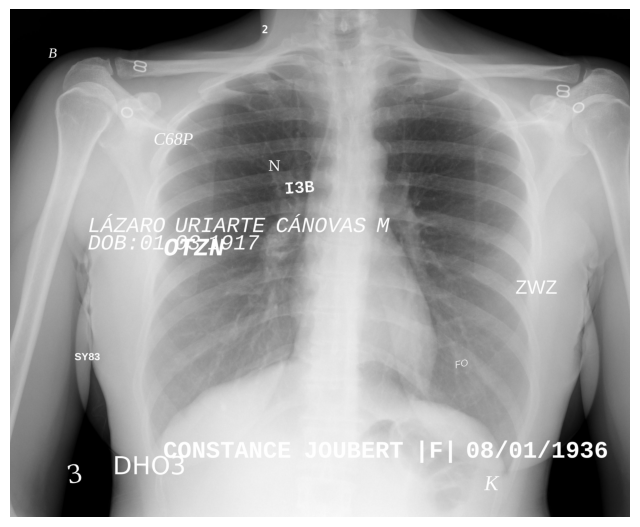

In [5]:
test_example = "3010bce1-6b9888c5-38a420ad-82d75a28-51a92ff3_22.jpeg"

test_bboxes = read_boxes_example("/mnt/hgfs/shared/coco/annotations/concat_annot.csv", os.path.join("/mnt/hgfs/shared/coco/new_custom_val_v2", test_example))

plot_example("/mnt/hgfs/shared/coco/new_custom_val_v2",test_example,test_bboxes)


In [7]:
filename = "3010bce1-6b9888c5-38a420ad-82d75a28-51a92ff3_22.jpeg"
bboxes = []
with open("/mnt/hgfs/shared/coco/annotations/concat_annot.csv", mode="r", newline="") as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        if filename in row["image_name"]:
            bboxes.append([int(row["bbox_x"]),int(row["bbox_y"]),int(row["bbox_width"]),int(row["bbox_height"])])
plot_example("/mnt/hgfs/shared/coco/new_custom_val_v2",filename,bboxes)

{'file_name': '810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_22.jpeg', 'width': 2089, 'height': 2846, 'id': 15470}
2089 2846


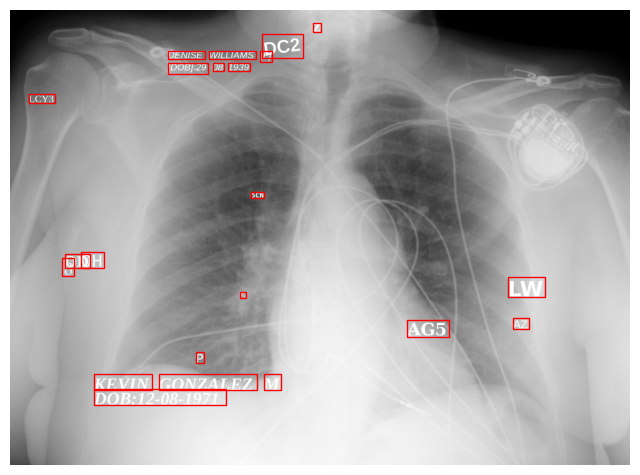

In [18]:
import json
filename = "810703c1-7dd36080-7e5d3a47-a6dc2884-d187211c_22.jpeg"
fileID = 15470
bboxes = []
with open("/home/nico/Downloads/new_custom_val_v2_big.json") as json_file:
    coco = json.load(json_file)
    
    for image in coco["images"]:
        if image["file_name"] == filename:
            print(image)

    for annot in coco["annotations"]:
        if annot["image_id"] == fileID:
            bboxes.append(annot["bbox"])
            
plot_example("/mnt/hgfs/shared/coco/new_custom_val_v2",filename,bboxes)